<a href="https://colab.research.google.com/github/Volviane/AMMI_Assignments/blob/master/AMMI_Cassava_GOST_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cassava Disease Classification

Classify pictures of cassava leaves into 1 of 4 disease categories (or healthy)  
Paper: https://arxiv.org/pdf/1908.02900.pdf

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

!mkdir /root/.kaggle
!ls -la /root/.kaggle
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/data/kaggle.json /root/.kaggle/

# To get the API token from kaggle (kaggle.json file)
!pip uninstall -y kaggle >/dev/null 2>&1
!pip install --upgrade pip >/dev/null 2>&1
!pip install kaggle==1.5.6 >/dev/null 2>&1
!kaggle -v 

#download data, will take 30-60 seconds
!kaggle competitions download -c ammi-2020-convnets

!cp /content/ammi-2020-convnets.zip /content/gdrive/My\ Drive/kaggle/cassava
!unzip -qq ammi-2020-convnets

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
total 12
drwxr-xr-x 2 root root 4096 May 10 13:48 .
drwx------ 1 root root 4096 May 10 13:48 ..
Kaggle API 1.5.6
100% 2.30G/2.30G [00:30<00:00, 33.3MB/s]
100% 2.30G/2.30G [00:30<00:00, 82.0MB/s]


In [0]:
# Colab's file access feature
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=False)

path = "/content/gdrive/My Drive/kaggle/cassava"

!unzip -qq "$path/ammi-2020-convnets.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F
from torchvision import datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pylab as plt
from PIL import Image
import cv2

import time
import os
import copy
import random
import math
import pprint
plt.ion()   # interactive mode

!pip install pretrainedmodels >/dev/null 2>&1
import pretrainedmodels

import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Exploration

In [0]:
!ls

ammi-2020-convnets.zip	gdrive	     sample_submission_file.csv
drive			random.txt   test
extraimages		sample_data  train


In [0]:
print('Train set:')
train_path = './train/train'

for cls in os.listdir(train_path):
    print('{} : {}'.format(cls, 
                         len(os.listdir(os.path.join(train_path, cls)))
                        ))
print()
im = Image.open(train_path + '/cgm/train-cgm-738.jpg')
print(im.size)

Train set:
cgm : 773
cbb : 466
cmd : 2658
cbsd : 1443
healthy : 316

(500, 500)


In [0]:
def setup_seed(seed, cuda):
    # Creates global random seed across torch, cuda and numpy 
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

## Settings

In [0]:
from argparse import Namespace

args = Namespace(
    size = 448,
    # Model Hyperparameters
    learning_rate = 2e-4,
    batch_size = 4,
    num_epochs = 20,
    valid_num_epochs = 10,
    early_stopping_criteria=10,
    momentum=0.9,

    # Data Parameters
    mean = torch.tensor([0.485, 0.456, 0.406]),
    std = torch.tensor([0.229, 0.224, 0.225]),
    validation_split = .1,
    shuffle_dataset = True,
    num_folds=5,

    seed= 0,

    # Paths
    save_dir = "/content/gdrive/My Drive/kaggle/cassava/",
    train_path = "./train",
    test_path = "./test/0",

    # Runtime hyper parameter
    cuda=True,


)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
setup_seed(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Using CUDA: True


In [0]:
# Save all pytorch downloads in this folder 
#%env TORCH_HOME=$args.save_dir

In [0]:
def get_labels(file_path): 
    dir_name = os.path.dirname(file_path)
    split_dir_name = dir_name.split("/")
    dir_levels = len(split_dir_name)
    label  = split_dir_name[dir_levels - 1]
    return(label)

In [0]:
from glob import glob
imagePatches = glob("./train/train/*/*.*", recursive=True)
imagePatches[0:5]

['./train/train/cgm/train-cgm-556.jpg',
 './train/train/cgm/train-cgm-554.jpg',
 './train/train/cgm/train-cgm-109.jpg',
 './train/train/cgm/train-cgm-686.jpg',
 './train/train/cgm/train-cgm-169.jpg']

In [0]:
images_df = pd.DataFrame(columns=['images', 'labels'])
images_df["images"] = imagePatches

y = []
for img in imagePatches:
    y.append(get_labels(img))   

images_df["labels"] = y

In [0]:
images_df.tail()

,images,labels
5651,./train/train/healthy/train-healthy-116.jpg,healthy
5652,./train/train/healthy/train-healthy-94.jpg,healthy
5653,./train/train/healthy/train-healthy-279.jpg,healthy
5654,./train/train/healthy/train-healthy-273.jpg,healthy
5655,./train/train/healthy/train-healthy-183.jpg,healthy


In [0]:

labelencoder = LabelEncoder()

images_df["labels"] = labelencoder.fit_transform(images_df["labels"])

## Extra Images

In [0]:
from glob import glob
extra_imagePatches = glob("./extraimages/extraimages/*.*", recursive=True)

extra_imagePatches[0:4]

['./extraimages/extraimages/extra-image-2854.jpg',
 './extraimages/extraimages/extra-image-3875.jpg',
 './extraimages/extraimages/extra-image-7301.jpg',
 './extraimages/extraimages/extra-image-1052.jpg']

In [0]:
ex_images_df = pd.DataFrame(columns=['images', 'labels'])
ex_images_df["images"] = extra_imagePatches
ex_images_df["labels"] = -1

In [0]:
class CassavaDataset(Dataset):
    def __init__(self, df_data, transform=None):
        super().__init__()
        self.df = df_data.values
        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path, label = self.df[index]
        
        image = Image.open(img_path)
        #image = cv2.resize(image, (500,500))

        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [0]:
train_trans = T.Compose([
        T.RandomResizedCrop(args.size),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.ToTensor(),
        T.Normalize(args.mean, args.std)
    ])

val_trans = T.Compose([
        T.Resize(500),
        T.CenterCrop(args.size),
        T.ToTensor(),
        T.Normalize(args.mean, args.std)
    ])

test_trans = T.Compose([
        T.Resize(500),
        T.CenterCrop(args.size),
        T.ToTensor(),
        T.Normalize(args.mean, args.std)
    ])

In [0]:
classes = labelencoder.classes_

print(classes)

['cbb' 'cbsd' 'cgm' 'cmd' 'healthy']


In [0]:
train_dataset = CassavaDataset(df_data=images_df, transform=train_trans)
train_loader = DataLoader(dataset = train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)

In [0]:
def imshow(source, size):
    img, labels = source
    plt.figure(figsize=(12,12))
    for i in range(8):
        plt.subplot(2, args.batch_size//2, i + 1)
        imt = (img[i].view(-1, size, size))
        imt = imt.numpy().transpose([1,2,0])
        imt = (args.std * imt + args.mean).clamp(0,1)
        plt.imshow(imt.squeeze(), cmap="gray")
        plt.title("{} ".format(classes[labels[i]]))

ValueError: ignored

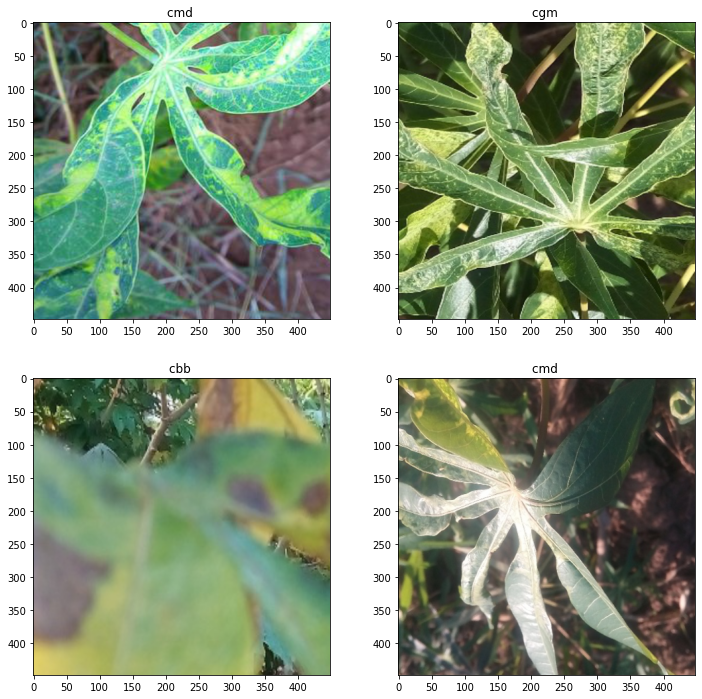

In [0]:
source = next(iter(train_loader))
imshow(source, size=args.size)

# Training

In [0]:
class LabelSmoothSoftmaxCE(nn.Module):
    def __init__(self,
                 lb_pos=0.9,
                 lb_neg=0.005,
                 reduction='mean',
                 lb_ignore=255,
                 ):
        super(LabelSmoothSoftmaxCE, self).__init__()
        self.lb_pos = lb_pos
        self.lb_neg = lb_neg
        self.reduction = reduction
        self.lb_ignore = lb_ignore
        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, logits, label):
        logs = self.log_softmax(logits)
        ignore = label.data.cpu() == self.lb_ignore
        n_valid = (ignore == 0).sum()
        label[ignore] = 0
        lb_one_hot = logits.data.clone().zero_().scatter_(1, label.unsqueeze(1), 1)
        label = self.lb_pos * lb_one_hot + self.lb_neg * (1-lb_one_hot)
        ignore = ignore.nonzero()
        _, M = ignore.size()
        a, *b = ignore.chunk(M, dim=1)
        label[[a, torch.arange(label.size(1)), *b]] = 0

        if self.reduction == 'mean':
            loss = -torch.sum(torch.sum(logs*label, dim=1)) / n_valid
        elif self.reduction == 'none':
            loss = -torch.sum(logs*label, dim=1)
        return loss

In [0]:
# warmup lr schedule
class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """

    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier <= 1.:
            raise ValueError('multiplier should be greater than 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super().__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)

In [0]:
def make_plot(history, plot_type='loss'):
    train = history[plot_type]['train']
    valid = history[plot_type]['valid']
    
    fig, ax = plt.subplots()
    ax.plot(train)
    ax.plot(valid)
    plt.legend(['train', 'valid'])
    
    title = 'Training vs Validation '+'plt_type'
    ax.set(xlabel='Epoch', ylabel=plot_type,
           title=title)
    ax.grid()

    plt.show()

In [0]:
def load_checkpoint(model, optimizer, filename=None): 
    # Note: Input model & optimizer should be pre-defined. This routine only updates their states. 
    start_epoch = 0 
    if os.path.isfile(filename): 
        print("=> loading checkpoint '{}'".format(filename)) 
        checkpoint = torch.load(filename) 
        start_epoch = checkpoint['epoch'] 
        model.load_state_dict(checkpoint['state_dict']) 
        #optimizer.load_state_dict(checkpoint['optimizer']) 
        print("=> loaded checkpoint '{}' (epoch {})" .format(filename,
                                                            checkpoint['epoch'])) 
    else: print("=> no checkpoint found at '{}'".format(filename)) 
    return model, optimizer, start_epoch

In [0]:
def se_resnext101_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext101_32x4d(pretrained=pretrained)
    return model

def se_resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    return model

def resnet50(pretrained=True):
    model = models.resnet50(pretrained=pretrained)
    return model       

In [0]:
class SEResnext101(nn.Module): 
    def __init__(self, model, num_classes=1000): 
        super().__init__() 
        self.backbone = model 
        #self.fc1 = nn.Linear(512, 128) 
        self.dropout = nn.Dropout(0.3) 
        #self.fc2 = nn.Linear(128, num_classes) 
        self.fc = nn.Linear(2048, 5) 
        # self.fc2 = nn.Linear(1024, num_classes)
        # self.conv_last = nn.Conv2d(2048, num_classes, 3) 
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x): 
        # x = whitening(x) 
        x = self.backbone.layer0(x) 
        x = self.backbone.layer1(x) 
        x = self.backbone.layer2(x) 
        x = self.backbone.layer3(x) 
        x = self.backbone.layer4(x) 
        x = self.avg_pool(x)
        x = self.dropout(x)  
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # x = self.fc2(x)

        return x

In [0]:
class ResNet50(nn.Module):
    def __init__(self, model, num_classes=1000):
        super(ResNet50, self).__init__()
        self.backbone = model

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2048, num_classes)
        self.conv_last = nn.Conv2d(512, num_classes, 1)
        

    def forward(self, x):
        # x = whitening(x)
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # print(x.size())
        x = self.backbone.avgpool(x)
        x = self.dropout(x)  

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [0]:
def get_model(model_name = 'se_resnext101_32x4d'):

    if model_name == 'se_resnext101_32x4d':
        base_model = se_resnext101_32x4d(pretrained=True)
        model_ft = SEResnext101(base_model, 5)

    elif model_name == 'se_resnext50_32x4d':
        model_ft = se_resnext50_32x4d(pretrained=False)
        model_ft.avg_pool = torch.nn.AdaptiveAvgPool2d(1)

        num_ftrs = model_ft.last_linear.in_features
        model_ft.last_linear = torch.nn.Linear(num_ftrs, 5)

    elif model_name == 'resnet50':
        base_model = models.resnet50(pretrained=True)
        model_ft = ResNet50(base_model, 5)

        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 5)

    model_ft = model_ft.to(args.device)
    return model_ft


In [0]:
model_ft = get_model(model_name = 'se_resnext101_32x4d')
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), 
                         lr=args.learning_rate, 
                         momentum=args.momentum)

# optimizer_ft = torch.optim.Adam(model_ft.parameters(), 
#                                lr=args.learning_rate, 
#                                 betas=(0.9, 0.999), 
#                                 weight_decay=0.0002)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth" to /root/.cache/torch/checkpoints/se_resnext101_32x4d-3b2fe3d8.pth


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(args.device)
                labels = labels.to(args.device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# Stratified K-Fold
st_kfold = StratifiedKFold(n_splits=args.num_folds, shuffle=True, random_state=args.seed)

In [0]:
fold = 0
for train_index, val_index in st_kfold.split(images_df['images'], images_df['labels']):
    train, val = images_df.iloc[train_index], images_df.iloc[val_index]

    train_dataset = CassavaDataset(df_data=train, transform=train_trans)
    valid_dataset = CassavaDataset(df_data=val,transform=val_trans)

    train_loader = DataLoader(dataset = train_dataset, 
                              batch_size=args.batch_size, 
                              shuffle=True, 
                              num_workers=4,
                              )
    valid_loader = DataLoader(dataset = valid_dataset, 
                              batch_size=args.batch_size, 
                              shuffle=False, 
                              num_workers=4,
                              )

    dataloaders = {'train': train_loader, 'val': valid_loader}
    
    dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}
    print(dataset_sizes)
    saved_dir = args.save_dir+str(fold)+'/'
    if fold == 0:
        print(f'Starting CV for Fold {fold}')

        model_ft = train_model(model_ft, criterion, 
                            optimizer_ft, 
                            exp_lr_scheduler, 
                            num_epochs=args.num_epochs,
                            )

    fold += 1
state = {'epoch': 2, 
            'state_dict': model_ft.state_dict(), 
            'optimizer': 'optimizer_ft.state_dict()', 
                'loss':'epoch_loss','valid_accuracy': 'best_acc'}
handle_dirs(saved_dir)
full_model_path = args.save_dir+'/model_state.tar'
#full_model_path = saved_dir+'model_state.tar'
torch.save(state, full_model_path)
print('Cross Validation Done ...')

{'train': 4524, 'val': 1132}
Starting CV for Fold 0
Epoch 0/19
----------
train Loss: 1.0406 Acc: 0.6019
val Loss: 0.6371 Acc: 0.7686

Epoch 1/19
----------
train Loss: 0.7136 Acc: 0.7396
val Loss: 0.4429 Acc: 0.8595

Epoch 2/19
----------
train Loss: 0.5915 Acc: 0.8002
val Loss: 0.3966 Acc: 0.8781

Epoch 3/19
----------
train Loss: 0.5260 Acc: 0.8229
val Loss: 0.4377 Acc: 0.8622

Epoch 4/19
----------
train Loss: 0.4704 Acc: 0.8442
val Loss: 0.3761 Acc: 0.8781

Epoch 5/19
----------
train Loss: 0.4426 Acc: 0.8475
val Loss: 0.3665 Acc: 0.8843

Epoch 6/19
----------
train Loss: 0.4069 Acc: 0.8607
val Loss: 0.3490 Acc: 0.8966

Epoch 7/19
----------
train Loss: 0.3693 Acc: 0.8786
val Loss: 0.3518 Acc: 0.8975

Epoch 8/19
----------
train Loss: 0.3397 Acc: 0.8855
val Loss: 0.3815 Acc: 0.8878

Epoch 9/19
----------


In [0]:
full_model_path = args.save_dir+'model_statefold3.tar'
final_model, optimizer, _ = load_checkpoint(model_ft, 
                                            optimizer_ft, 
                                            filename=full_model_path,
                                            )

=> loading checkpoint '/content/gdrive/My Drive/kaggles/cassava/model_statefold3.tar'
=> loaded checkpoint '/content/gdrive/My Drive/kaggles/cassava/model_statefold3.tar' (epoch 2)


## Retrain on entire dataset

In [0]:
def train_all_model(model, 
                    criterion, 
                    optimizer, 
                    scheduler, 
                    num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in dataloaders:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(args.device)
                labels = labels.to(args.device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
train_dataset = CassavaDataset(df_data=images_df, 
                               transform=train_trans)
train_loader = DataLoader(dataset = train_dataset, 
                          batch_size=args.batch_size, 
                          shuffle=True, 
                          num_workers=4,
                          )

dataloaders = {'train': train_loader}

dataset_sizes = {'train': len(train_dataset)}

# init_model = copy.deepcopy(model)
model_ft_whole_dataset = train_all_model(model_ft, 
                                         criterion, 
                                         optimizer_ft, 
                                         exp_lr_scheduler, 
                                         num_epochs=args.valid_num_epochs,
                                         )

print('Training Done ...')

## Prediction  

### Train Final Model

### Initiate Predictions

In [0]:
sample_sub_file_path = 'sample_submission_file.csv'
df_test = pd.read_csv(sample_sub_file_path)
test_data = df_test['Id']
df_test.head()

,Category,Id
0,cbsd,test-img-0.jpg
1,cmd,test-img-1.jpg
2,cbb,test-img-2.jpg
3,cmd,test-img-3.jpg
4,cbsd,test-img-4.jpg


In [0]:
def crop_image(im, crop_idx):
    w, h = im.size
    if crop_idx == 0:
        im = im.crop((0, 0, int(w*0.9), int(h*0.9))) # top left
    elif crop_idx == 1:
        im = im.crop((int(w*0.1), 0, w, int(h*0.9))) # top right
    elif crop_idx == 2:
        im = im.crop((int(w*0.05), int(h*0.05), w-int(w*0.05), h-int(h*0.05))) # center
    elif crop_idx == 3:
        im = im.crop((0, int(h*0.1), w-int(w*0.1), h)) # bottom left
    elif crop_idx == 4:
        im = im.crop((int(w*0.1), int(h*0.1), w, h)) # bottom right
    elif crop_idx == 5:
        im = im.crop((0, 0, int(w*0.9), int(h*0.9))) 
        im = im.transpose(Image.FLIP_LEFT_RIGHT) # top left and HFlip
    elif crop_idx == 6:
        im = im.crop((int(w*0.1), 0, w, int(h*0.9)))
        im = im.transpose(Image.FLIP_LEFT_RIGHT) # top right and HFlip
    elif crop_idx == 7:
        im = im.crop((int(w*0.05), int(h*0.05), w-int(w*0.05), h-int(h*0.05)))
        im = im.transpose(Image.FLIP_LEFT_RIGHT) # center and HFlip
    elif crop_idx == 8:
        im = im.crop((0, int(h*0.1), w-int(w*0.1), h))
        im = im.transpose(Image.FLIP_LEFT_RIGHT) # bottom left and HFlip
    elif crop_idx == 9:
        im = im.crop((int(w*0.1), int(h*0.1), w, h))
        im = im.transpose(Image.FLIP_LEFT_RIGHT) # bottom right and HFlip
    return im

In [0]:
class CassavaTestDataset(Dataset):
    def __init__(self, df_data, transform=None, tta=False, tta_idx=0, data_path='./test/test/0/'):
        super().__init__()
        self.df = df_data.values
        self.transform = transform
        self.tta=tta
        self.tta_idx = tta_idx
        self.data_path = data_path

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_name = self.df[index]
        img_path = os.path.join(self.data_path, image_name)
        image = Image.open(img_path)
        #image = cv2.resize(image, (500,500))
        if self.tta:
           image = crop_image(image, crop_idx=self.tta_idx)

        if self.transform is not None:
            image = self.transform(image)

        return image, image_name

In [0]:
def inference(model, transform, test_data, data_path='./test/test/0/'):
    since = time.time()
    
    test_dataset = CassavaTestDataset(test_data, transform=transform, data_path=data_path)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=args.batch_size//2)

    model.eval()
    results = []
    print('Inferencing ...')
    for images, image_names in test_loader:
        images = images.to(args.device)
        output = model(images)
        preds = torch.argmax(output, dim=-1)
        preds = preds.cpu().detach().numpy()

        for pred, image_name in zip(preds, image_names):
            results.append({'Id':image_name, 'Category': classes[pred]})

    df = pd.DataFrame(results, columns=['Category', 'Id'])
    df.to_csv('sub.csv', index=False)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [0]:
cls2label = {}
for label, cls in enumerate(classes):
    cls2label[cls] = label
print(cls2label)

{'cbb': 0, 'cbsd': 1, 'cgm': 2, 'cmd': 3, 'healthy': 4}


In [0]:
def inference_TTA(model, transform, test_data, num_of_tta=10, data_path='./test/test/0/'):  
    since = time.time()

    assert num_of_tta <= 10, "TTA number must not be more than 10"

    TTA10 = []
    results = []
    print(f'Inferencing with {num_of_tta} TTA ...')

    for tta_idx in range(num_of_tta):
        test_dataset = CassavaTestDataset(test_data, transform=transform, tta=True, tta_idx=tta_idx, data_path=data_path )
        
        test_loader = DataLoader(test_dataset, shuffle=False, batch_size=args.batch_size//2, num_workers=0)
        model.eval()

        names2probs = {}
        for images, image_names in test_loader:
            images = images.to(args.device)
            output = model(images)

            probs = F.softmax(output, dim=-1)
            probs = probs.cpu().detach().numpy()
            for prob, image_name in zip(probs, image_names):
                names2probs[image_name] = prob

        TTA10.append(names2probs)

    for im_name in TTA10[0]:
        # Find average of all prediction probabilities for each class
        avg_prob = torch.zeros(5)
        for prob_idx in range(num_of_tta):
            avg_prob += TTA10[prob_idx][im_name]

        avg_prob = avg_prob/num_of_tta
        pred = torch.argmax(avg_prob)
        pred = pred.cpu().detach().numpy()

        results.append({'Id':im_name, 'Category':classes[pred]})

    df = pd.DataFrame(results, columns=['Category', 'Id'])
    df.to_csv('sub_tta.csv', index=False)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [0]:
inference(model=model_ft_whole_dataset, 
          transform=test_trans, 
          test_data=test_data)

In [0]:
prediction_without_TTA = pd.read_csv('./sub.csv')

In [0]:
prediction_without_TTA.head(15)

,Category,Id
0,cbsd,test-img-0.jpg
1,cbsd,test-img-1.jpg
2,cmd,test-img-2.jpg
3,cmd,test-img-3.jpg
4,cmd,test-img-4.jpg
5,cmd,test-img-5.jpg
6,cbb,test-img-6.jpg
7,cmd,test-img-7.jpg
8,cmd,test-img-8.jpg
9,cbsd,test-img-9.jpg


In [0]:
inference_TTA(model=final_model,
              transform=test_trans, 
              test_data=test_data, 
              num_of_tta=10,
              )

Inferencing with 10 TTA ...
Training complete in 56m 33s


In [0]:
prediction_with_TTA = pd.read_csv('./sub_tta.csv')

In [0]:
prediction_with_TTA.tail()

,Category,Id
3769,cbsd,test-img-3769.jpg
3770,cmd,test-img-3770.jpg
3771,cbsd,test-img-3771.jpg
3772,cbb,test-img-3772.jpg
3773,cbsd,test-img-3773.jpg


## Pseudo prediction for extra images

In [0]:
saved_dir = args.save_dir+str(0)+'/'
full_model_path = saved_dir+'/model_state_ResNext101_Adam.tar'

In [0]:
model_ft, _, _ = load_checkpoint(model_ft, optimizer_ft, filename=full_model_path)

=> loading checkpoint '/content/gdrive/My Drive/kaggle/cassava/0//model_state_ResNext101_Adam.tar'
=> loaded checkpoint '/content/gdrive/My Drive/kaggle/cassava/0//model_state_ResNext101_Adam.tar' (epoch 2)


In [0]:
inference(model=model_ft, 
          transform=test_trans, 
          test_data=ex_images_df["images"], 
          data_path='./extraimages/extraimages/')

Inferencing ...
Training complete in 17m 29s


In [0]:
pd.read_csv('./sub.csv')

,Category,Id
0,cmd,extra-image-2913.jpg
1,cgm,extra-image-6098.jpg
2,cgm,extra-image-9851.jpg
3,cmd,extra-image-10566.jpg
4,cmd,extra-image-6007.jpg
...,...,...
12590,cmd,extra-image-14836.jpg
12591,cbb,extra-image-8724.jpg
12592,cmd,extra-image-12282.jpg
12593,healthy,extra-image-5079.jpg


In [0]:
extra_images_df = pd.read_csv(args.save_dir+'final_pseudo_labels_without_cmd.csv')
extra_images_df['images'] = extra_images_df['images'].apply(lambda x : './extraimages/extraimages/'+x )
extra_images_df.head()

In [0]:
total_train_data_df = pd.concat([images_df, extra_images_df])